# Tutorial 7: Tensorflow and neural networks

Welcome to the seventh tutorial of the course 'Machine learning for Precision Medicine'.

In this exercise we will look at a subset the skin MNIST dataset from [kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000). 

The original datasets includes more than 10,015 images of pigmented lesions with the diagnostic categories: 
- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
- basal cell carcinoma (bcc) 
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
- dermatofibroma (df) 
- melanoma (mel)
- melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
np.random.seed(123)

import itertools
from helper_functions import random_mini_batches

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
print(f'Tensor Flow version: {tf.VERSION}')

Tensor Flow version: 1.13.1


## Data preprocessing

load_data() from helper_functions:   
- Subset of images  
- Subset of features: basal cell carcinoma, melanoma and melanocytic-nevi  

In [2]:
from IPython.display import display, Image
# Caution: sensative imaging data
# display(Image(filename='./image_samples.png'))

The original image size was (75, 100, 3). The '3' as the last number of the shape, indicates that we are dealing with RGB-images here. 3 for the 3 color channels red, green and blue. Then we reduced the image resolution to 28x28 pixels (resulting in a shape of (28,28,3)), so that we can easily pass it into our model later. 

To make it easier to load the data: numpy-vectors X_train, X_test, y_train, y_test.   
I.e. X_train contains the flattened image vectors of all training images. When you flatten the dimensions (28,28,3) of an image, then you get a flat vector of 2352 from 28\*28\*3. The X_train vector containes these flattened image-vectors stacked from all images. Same procedure was applied for the test vector.

In [3]:
X_train = np.load('./X_train.npy')
print('number of training samples: ', len(X_train))
print('Shape of X_train', X_train.shape)

X_test = np.load('./X_test.npy')
print('number of test samples: ', len(X_test))
print('Shape of X_test', X_test.shape)

y_train = np.load('./y_train.npy')
print('Shape of y_train', y_train.shape)

y_test = np.load('./y_test.npy')
print('Shape of y_test', y_test.shape)

number of training samples:  5832
Shape of X_train (5832, 2352)
number of test samples:  2500
Shape of X_test (2500, 2352)
Shape of y_train (5832, 3)
Shape of y_test (2500, 3)


We have to transform the vectors for later

In [4]:
X_train = X_train.T
print('Shape of X_train', X_train.shape)

X_test = X_test.T
print('Shape of X_test', X_test.shape)

y_train = y_train.T
print('Shape of y_train', y_train.shape)

y_test = y_test.T
print('Shape of y_test', y_test.shape)

Shape of X_train (2352, 5832)
Shape of X_test (2352, 2500)
Shape of y_train (3, 5832)
Shape of y_test (3, 2500)


Below mentioned image shows how the downsampled image looks like. For plotting, we have to transform the flattened shape back into its pixel and channel shape, as required by the imshow function.   
Change the number to see different samples.

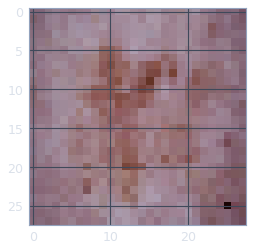

In [5]:
x = X_train[:,1040].reshape(28,28,3)
plt.imshow(x)

# Introduction to Tensorflow

This week's Exercise will give you an introduction to the most popular deep-learning framework [Tensorflow](https://www.tensorflow.org/]), which is developed and maintained by Google.

We will first go over the concepts behind Tensorflow, in particular **Tensors** (variables, constants and placeholders), **initialization**, and building a **computational graph**, which we execute inside a tensorflow session.

Afterwards we implement a simple fully connected network "from scratch" to perform an image classification tasks with a subset of the [skin-cancer MNIST](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) data.


## Tensors and Programming in Tensorflow

Taken from the Tensoflow [documentation](https://www.tensorflow.org/guide/tensors):

*&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;TensorFlow, as the name indicates, is a framework to define and run computations involving tensors. A tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes.*

*&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; When writing a TensorFlow program, the main object you manipulate and pass around is the **tf.Tensor**. A tf.Tensor object represents a partially defined computation that will eventually produce a value. TensorFlow programs work by first building a graph of tf.Tensor objects, detailing how each tensor is computed based on the other available tensors and then by running parts of this graph to achieve the desired results.*

Writing and running programs in Tensorflow requires the following steps:

1. Define a set of Tensors (variables, constants or placeholders)
2. Write operations among those Tensors (which will produce other Tensors)
3. Initialize the Tensors you defined in step 1.
4. Create a Session
5. Run the Session. This will run the operations you defined in step 2.

Programming this way in Tensorflow can feel a bit verbose and abstract. For this reason a lot of effort is being made in order to make Tensorflow easier to work with, especially for beginners (see the  [Tensorflow 2.0 alpha](https://www.tensorflow.org/alpha)). We will discuss some of these changes and higher level frameworks like [Keras](https://keras.io/) in later exercises. However, this exercise will be performed in the "classical" Tensorflow way following the steps above using as little abstraction as possible.

Perform all of the steps mentioned above:

In [6]:
# defining tensors a and b (step 1)
a = tf.constant(2.)
b = tf.constant(5.)

x = tf.placeholder(tf.float32, name='x')

# defining operations between them (step 2)
c = tf.multiply(a,x)
d = tf.multiply(b,c)

assert str(d) == 'Tensor("Mul_1:0", dtype=float32)', "output does not match"
print(d)

Tensor("Mul_1:0", dtype=float32)


**Expected output:**
    Tensor("Mul_1:0", dtype=float32)


When we print `d`, we simply get the non-evaluated Tensor object. This is because we only defined a **computational graph**, but we did not execute it.

In order to run the computations in our graph, we have to create a `tf.Session` and run it:

In [7]:
# we skip initialization (step 3), as we do not need to initialize constants...
# we start a tf.Session (step 4)
with tf.Session() as sess:
    # we run the session to produce 'd' (step 5)
    output = sess.run(d, feed_dict={x: 1.})
    assert int(output) == 10, "output does not match"
    print(output)

10.0


**Expected output:**
    10.0

This gives the desired result for `x = 1.`. Note that we used `feed_dict` in order to pass the value for `x`, which we defined to be a placeholder. A placeholder is a Tensor for which we will *feed* a value when we run the session. We can feed in different values for `x` this way:

In [8]:
with tf.Session() as sess:
    # we feed x = 2. instead of x = 1.
    output = sess.run(d, feed_dict={x: 2.})
    assert int(output) == 20, "output does not match"
    print(output)

20.0


**Expected output:**
    20.0

The graph we are actually executing here is the default graph:

In [9]:
tf.get_default_graph()

If we clear the graph before executing the code above, we will get an error:

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    try:
        sess.run(d, feed_dict={x: 2.})
    except RuntimeError as e:
        assert str(e) == "The Session graph is empty.  Add operations to the graph before calling run()." , "wrong error"
        print(e)

The Session graph is empty.  Add operations to the graph before calling run().


**Expected output**  
The Session graph is empty.  Add operations to the graph before calling run().

The graph we defined above made use of constants and placeholders. We can also define variables (as opposed to constants), which can change their values between executions of the graph, and which are typically only initialized once in the beginning. Variables are used for trainable parameters. For example, we could set up a linear model with a single input and output variable like this:

In [11]:
# build the computational graph:
tf.reset_default_graph()

tf.set_random_seed(1)

# define the input:
x = tf.placeholder(tf.float32, name='x')

# define the operations: y_hat = x*w + b
b = tf.get_variable('b', shape=[1], dtype=tf.float32, initializer=tf.zeros_initializer())
w = tf.get_variable('w', shape=[1], dtype=tf.float32, initializer=tf.initializers.random_normal())
z = tf.multiply(x, w)
y_hat = tf.add(z, b)

# the desired output we will compare against:
y = tf.placeholder(tf.float32, name='y')

# the loss (squared error):
loss = tf.square(tf.subtract(y, y_hat))

# the initialization operation:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    # initialize the variables:
    sess.run(init)
    
    # get the value for w: tensor with a normal distribution
    print('w: {}'.format(sess.run(w)))
    
    # get the value for b: a zero
    print('b: {}'.format(sess.run(b)))
    
    # get the value for y_hat after random initialization of w and x = 1.
    print('y_hat: {}'.format(sess.run(y_hat, feed_dict={x:1.})))
        
    # get the loss for x = 1. and y = 1. 
    print('loss: {}'.format(sess.run(loss, feed_dict={x:1., y:1.})))
    

Instructions for updating:
Colocations handled automatically by placer.
w: [-0.12510145]
b: [0.]
y_hat: [-0.12510145]
loss: [1.2658533]


**Expected output**  
w: [-0.12510145]
b: [0.]
y_hat: [-0.12510145]
loss: [1.2658533]

We see that `w` (our weight variable) was initialized randomly, while `b` (the bias variabe) was initialized with 0. This is because we explicitely set different initializers for the two variables using `initializer= ...`.

Above we simply defined a forward pass through a linear regression model. "Under the hood" Tensorflow has already defined the backward pass. We can optimize the parameters of our model by defining an `optimizer` object. You have to call this object along with the loss when running the tf.Session. When called, it will perform an optimization on the given loss with the chosen method and learning rate.

For instance, if we want to use gradient descent the optimizer would be:

iteration 01 -> loss: [1.2658533], w: [0.09991884], b: [0.22502029]
iteration 02 -> loss: [0.45570716], w: [0.23493102], b: [0.36003247]
iteration 03 -> loss: [0.16405457], w: [0.31593832], b: [0.44103977]
iteration 04 -> loss: [0.05905965], w: [0.3645427], b: [0.48964414]
iteration 05 -> loss: [0.02126148], w: [0.39370534], b: [0.51880676]
iteration 06 -> loss: [0.00765414], w: [0.41120294], b: [0.53630435]
iteration 07 -> loss: [0.00275549], w: [0.4217015], b: [0.5468029]
iteration 08 -> loss: [0.00099197], w: [0.42800063], b: [0.553102]
iteration 09 -> loss: [0.00035711], w: [0.4317801], b: [0.5568815]
iteration 10 -> loss: [0.00012856], w: [0.4340478], b: [0.55914915]


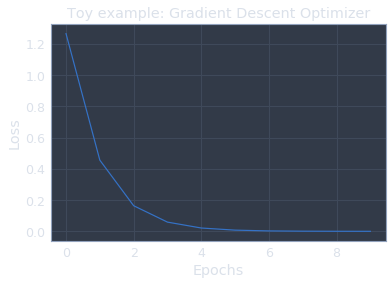

In [12]:
# define the optimizer:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

loss_hist = []

with tf.Session() as sess:
    
    # initialize the variables:
    sess.run(init)
    
    # perform 10 steps of optimization:
    for i in range(10):
        
        # we simply pass the same obsevation (x = 1. and y = 1.) 10 times 
        _, c = sess.run([optimizer, loss], feed_dict={x: 1., y: 1.})
        loss_hist +=[c]
        weight = sess.run(w)
        bias = sess.run(b)
        
        print('iteration {:0>2} -> loss: {}, w: {}, b: {}'.format(i+1, c, weight, bias))

plt.title("Toy example: Gradient Descent Optimizer")
plt.plot(loss_hist)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

We can see the loss going down and the variables `w` and `b` changing after each iteration. Of course it doesn't make much sense to optimize the parameters for a single observation (`x = 1. , y = 1.`) - this is just an illustrative example. But we now already have everything we need in order to start building and optimizing models with Tensorflow.

## Skin Cancer MNIST prediction 

We will break down the process of defining your feed-forward neural network in to multiple sub-tasks. Here make use of low-level tensorflow objects in order to implement this model. In a later exercise, we will make use of more abstract objects and operations.

But first, let's have a look at the dataset:

Complete the function `create_placeholders`. It takes the length of a single observation $\mathbf{x}$ (`n_x`) and the length of the target variable $\mathbf{y}$ ( `n_y` which is equal to the number of classes) as input, and returns two `tf.placeholder` objects.  We will feed batches of observations to these objects during training.

The last dimension, which is the "batch dimension" of these objects and which is defined by the `shape` parameter should be `None`. This will allow tensorflow to automatically infer it when we pass batches of a certain size later.


In [13]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
        
    X = tf.placeholder(tf.float32, shape=[n_x, None] ,name='X')
    Y = tf.placeholder(tf.float32, shape=[n_y, None] ,name='Y')
    
    return X, Y

As we did in our last exercise, we define the architecture using a list of dictionaries:

In [14]:
NN_ARCHITECTURE = [
    {"input_dim": 2352, "output_dim": 25, "activation": "relu"},
   {"input_dim": 25, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 3, "activation": "sigmoid"},
] 

## Task 2:

Complete the function `initialize_parameters`. It takes an architecture like the one defined in the cell above, and returns a list of dictionaries `parameters` with the following format:

```
[ {weights: W1, bias: b1},
  {weights: W2, bias: b2},
  ....
  {weights: Wn, bias: bn} ]
```

where `W1, W2, b1, b2, Wn, bn` etc are variables returned by the `tf.get_variable` function for layers 1 - n.

You will also have to specify the correct shapes for `W` and `b`. If you are unsure what the correct shapes are, remind yourself of the operation each layer will perform (and look at the previous exercise):

$$ \mathbf{Z}^{\{n\}} = \mathbf{W}^{\{n\}} \mathbf{A}^{\{n-1\}} + \mathbf{b}^{\{n\}} $$

Again, $\mathbf{b}$ is added via broadcasting.

Use `tf.initializers.he_normal(i)` as the initializer for `W`, and `tf.zeros_initializer()` as the initializer for `b`. The names for the variables should be 'W1', 'W2', ..., 'Wn' and 'b1', 'b2', ..., 'bn' for layers 1 - n. Here we use a initialization method proposed by [He et al., 2015](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html).

In [15]:
def initialize_parameters(architecture):
    
    """
    Creates the variables for the tensorflow session.
    
    Arguments:
    architecture -- list of dictionaries of with layer configurations (input_dim, output_dim, activation)
    
    Returns:
    parameters --  list of dictionaries with layer parameters (weights, bias)
    """
    
    tf.set_random_seed(1)
    
    # initialize the list
    parameters = []
    
    for i, param in enumerate(architecture):
        
        input_dim = param["input_dim"]
        output_dim = param["output_dim"]
        
        W = tf.get_variable("W{}".format(i+1), [output_dim, input_dim], initializer=tf.initializers.he_normal(i))
        b = tf.get_variable("b{}".format(i+1), [output_dim, 1], initializer=tf.zeros_initializer())
        
        
        layer_parameters = {}
        
        layer_parameters["weights"] = W
        layer_parameters["bias"] = b
        
        parameters.append(layer_parameters)
        
    return parameters


Let's create the session here and initialize the parameters for the model architecture. 

In [16]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(NN_ARCHITECTURE)
    
    for i in range(len(NN_ARCHITECTURE)):
    
        print("weights of layer {} = ".format(i+1) + str(parameters[i]["weights"]))
        print("   bias of layer {} = ".format(i+1) + str(parameters[i]["bias"]))


weights of layer 1 = <tf.Variable 'W1:0' shape=(25, 2352) dtype=float32_ref>
   bias of layer 1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
weights of layer 2 = <tf.Variable 'W2:0' shape=(25, 25) dtype=float32_ref>
   bias of layer 2 = <tf.Variable 'b2:0' shape=(25, 1) dtype=float32_ref>
weights of layer 3 = <tf.Variable 'W3:0' shape=(3, 25) dtype=float32_ref>
   bias of layer 3 = <tf.Variable 'b3:0' shape=(3, 1) dtype=float32_ref>


**Expected Output:**  
weights of layer 1 = <tf.Variable 'W1:0' shape=(25, 2352) dtype=float32_ref>  
   bias of layer 1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>  
weights of layer 2 = <tf.Variable 'W2:0' shape=(25, 25) dtype=float32_ref>  
   bias of layer 2 = <tf.Variable 'b2:0' shape=(25, 1) dtype=float32_ref>  
weights of layer 3 = <tf.Variable 'W3:0' shape=(25, 25) dtype=float32_ref>  
   bias of layer 3 = <tf.Variable 'b3:0' shape=(25, 1) dtype=float32_ref>  
weights of layer 4 = <tf.Variable 'W4:0' shape=(3, 25) dtype=float32_ref>  
   bias of layer 4 = <tf.Variable 'b4:0' shape=(3, 1) dtype=float32_ref>  


## Task 3:
We now define the forward pass through our model.

Complete the function `forward_propagation`. It takes as input the placeholder tensor `X`, the `architecture` and `parameters` which are defined above. For all layers, these are the operations that have to be performed:

$$  \mathbf{Z}^{\{l\}} = \mathbf{W}^{\{l\}} \mathbf{A}^{\{l-1\}} + \mathbf{b}^{\{l\}} $$
$$  \mathbf{A}^{\{l\}} = \phi^{\{l\}}(\mathbf{Z})  $$

Where $\mathbf{A}^{\{0\}} = \mathbf{X}_t$ and $\mathbf{b}^{\{l\}}$ is added to the matrix $\mathbf{W}^{\{l\}} \mathbf{A}^{\{l-1\}}$ via [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html). We can think of the scalar b being stretched during addition into an array with the same shape as WA. 


In [17]:
def forward_propagation(X, architecture, parameters):
    
    """
    Implements the forward propagation for the model (builds part of the computational graph)
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    architecture -- list of dictionaries, each dictionary contains "input_dim", 
    "output_dim" and "activation" for a single layer
    parameters -- list of dictionaries, each dictionary contains "weights" and "bias" 
    for a single layer

    Returns:
    -- the output of the last LINEAR unit (Zn)
     
    """
    # forward prop initialization:
    A = X
    
    for i, layer_parameters in enumerate(parameters):
        
        # linear transformation
        Z = tf.add(tf.matmul(layer_parameters["weights"],A),layer_parameters["bias"])
        
        if i == len(parameters) - 1:
            # return Z if we are in the last layer
            return Z
        else:
            # otherwise apply the activation function
            if architecture[i]['activation'] == 'relu':
                A = tf.nn.relu(Z)
            else:
                raise NotImplementedError('activation '+architecture[i]['activation']+' not implemented!')
                

In [18]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(2352, 3)
    parameters = initialize_parameters(NN_ARCHITECTURE)
    Zn = forward_propagation(X, NN_ARCHITECTURE, parameters)
    print("Zn = " + str(Zn))

Zn = Tensor("Add_2:0", shape=(3, ?), dtype=float32)


**Expected Output**:  
```
Zn = Tensor("Add_3:0", shape=(3, ?), dtype=float32)
```

## Task 4:

Once we have the output $\mathbf{Z}^{\{n\}}$ of the last layer, we will calculate the loss. Here we will implement two cases, corresponding to two activation functions sigmoid or softmax:

1. if the activation function is sigmoid (single class or multi-label), use `tf.nn.sigmoid_cross_entropy_with_logits`
2. if the activation function is softmax (multi class), use `tf.nn.softmax_cross_entropy_with_logits`

Tensorflow implements numerically stable versions of the cross-entropy loss that take the logits (i.e. the values in $\mathbf{Z}^{\{n\}}$) instead of the predicted probabilities as input.

Remember, the loss for a $m$ samples is given my the average accross all samples. Use `tf.reduce_mean` to get the average accross all samples.

In [19]:
def compute_loss(Y, Z, activation='sigmoid'):
    
    """
    Implements the calculation of the loss
    
    Arguments:
    Y -- output dataset placeholder, of shape (output size, number of examples)
    Z -- tensor containing the output of the last hidden layer (without applying the activation function)
    activation -- activation function for the last hidden layer

    Returns:
    loss -- 
    
    Tips:
     - use tf.nn.sigmoid_cross_entropy_with_logits or tf.nn.softmax_cross_entropy_with_logits depending on the activation function
     - use tf.reduce_mean to get the average accross samples 
     
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    inputs ={
    "logits": tf.transpose(Z)
    ,"labels": tf.transpose(Y)
    }
    if activation == 'sigmoid':
        loss = tf.nn.sigmoid_cross_entropy_with_logits(**inputs)
    elif activation == 'softmax':
        loss = tf.nn.softmax_cross_entropy_with_logits(**inputs)
    else:
        raise ValueError('activation has to be either sigmoid or softmax!')
        
    return tf.reduce_mean(loss)


## Task 5:

We will now bring everything together in the `model` function. Complete the function by using the functions you implemented above:

In [20]:
def calculate_accuracy(Z_n, Y, architecture):
    # Calculate the correct predictions
    if architecture[-1]["activation"] == "sigmoid":
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(Z_n, tf.constant(0.5)), "float"), Y)
    elif architecture[-1]["activation"] == "softmax":
        correct_prediction = tf.equal(tf.argmax(Z_n), tf.argmax(Y))
        
    # Calculate accuracy on the test set. Hint: use tensorflows reduce-mean() and cast function
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    return accuracy    

In [21]:
from IPython.display import clear_output
def update_progress(progress):
    # displays a progress bar
    bar_length = 50
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [22]:
import time
def model(X_train, Y_train, X_test, Y_test, architecture, learning_rate = 0.0001,
          num_epochs=1000, minibatch_size = 32, print_loss = True):
   
    text = ""
    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
    
    tf.set_random_seed(1)      # to keep consistent results
    seed = 3                   # to keep consistent results
    
    (n_x, m) = X_train.shape   # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]        # n_y : output size, i.e. the number of classes
    
    loss_history = []          # To keep track of the loss
    
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize objects for the parameters (weights and biases) with our function from above
    parameters = initialize_parameters(architecture)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph with our function from above
    Z_n = forward_propagation(X, architecture, parameters)
    
    # Loss function: Add loss function to tensorflow graph
    loss = compute_loss(Y, Z_n, architecture[-1]["activation"])
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
         
        # Do the training loop
        start = time.time()
        for epoch in range(num_epochs):
            
            epoch_loss = 0.                            # Defines a loss related to an epoch
            epoc_acc = 0.
            num_minibatches = int(m / minibatch_size)  # number of minibatches per epoch
            
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feed_dict should contain a minibatch for (X, Y).
                
                _ , minibatch_loss, y_hat = sess.run([optimizer, loss, Z_n], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                #epoc_acc, _ = tf.metrics.accuracy(minibatch_Y, y_hat)
                
                 
                #tf.cast(tf.reduce_mean(epoc_acc),"float")
                epoch_loss += minibatch_loss / num_minibatches
            
            #epoc_acc = calculate_accuracy(Z_n, Y_train, architecture).eval({X: X_train, Y: Y_train})
            # Print the cost every epoch
            if print_loss == True and epoch % 10 == 0:
               
                text = "epoch %d  loss: %f acc: %f" % (epoch,epoch_loss,epoc_acc )
            if print_loss == True:# and epoch % 5 == 0:
                
                loss_history.append(epoch_loss)
            
            update_progress(epoch/num_epochs)
            print(text)
        
        end = time.time()
        # plot the cost
        plt.plot(np.squeeze(loss_history))
        plt.ylabel('Loss')
        plt.xlabel('Iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained in %f s!"%(end - start))

        accuracy = calculate_accuracy(Z_n, Y, architecture)
        
        train_acc = accuracy.eval({X: X_train, Y: Y_train})
        test_acc= accuracy.eval({X: X_test, Y: Y_test})
        print ("Train Accuracy:", train_acc )
        print ("Test Accuracy:", test_acc)
        
        return parameters, train_acc, test_acc

Progress: [#############################################-----] 90.0%
epoch 0  loss: 5514.050831 acc: 0.000000


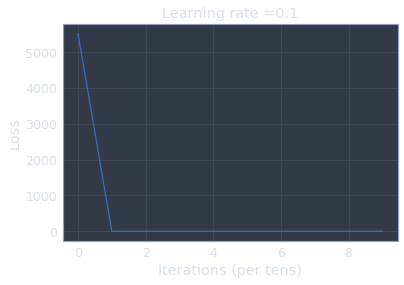

Parameters have been trained in 4.049042 s!
Train Accuracy: 0.87208503
Test Accuracy: 0.8645333


In [31]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = [1, 3, 5, 10, 50, 100]
minibatch_sizes = [16, 32, 64,128]
results = []

for l in learning_rates:
    tmp=[]
    for m in minibatch_sizes:
        params, train,test = model(X_train, y_train, X_test, y_test
           ,NN_ARCHITECTURE, num_epochs=10
           ,learning_rate=l, minibatch_size=m)
        tmp.append((train,test))
    results.append(tmp)

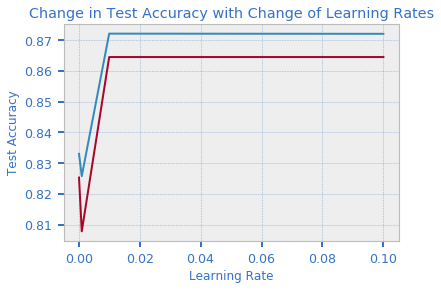

In [54]:
fig, ax = plt.subplots()

plt.plot(learning_rates,[x[:][1] for x in results])
# plt.style.use("bmh")
plt.xlabel("Learning Rate", color='b')
plt.ylabel("Test Accuracy", color='b')
plt.title("Change in Test Accuracy with Change of Learning Rates", color='b')
ax.tick_params(direction='out', length=6, width=2, colors='b',
               grid_color='b', grid_alpha=0.5)

**Question:**  
Play around with the architecture, (i.e. add another layer), learning rate, epochs, ... as far the your computer allows it. Did you find a constellation, that gives a better result? 

If we set the learning rate lower, for example to 0.00005, theoretically the accuracy should improve, because the gradient descent descends more slowly and precisely. <br>
Small mini-batches learn quicker, but larger mini-batches should perform better over time. Therefore, we increased the mini-batch size to 128 and it improved the results. Decresing the mini-batch size worsened the results. <br>
Changing the activation function of the last layer from softmax to sigmoid improved the results quiet strongly. <br>
Decreasing the number of epochs didn't worsen the outcome, as the algorithm converges quite soon. Especially when the learning rate was increased to speed up training.<br>
For example, when we trained with the learning rate 0.01, just 3 epochs, and mini-batch size 128 the test accuracy was 0.858. The net had only input layer and output layer. The activation of the output layer was sigmoid.
Increasing the number of epochs from 3 to 300 increases the test accuracy only by 0.1, yielding 0.8648. The Training accuracy is then by 0.872.